# Clustering Big Data with DBSCAN and H2O-3 Aggregator

Unsupervised algorithm `Aggregator` was introduced in H2O-3 release Turchin (3.8.2.3) on 4/25/2016. Aggregator is a clustering-based method to reduce numerical/categorical dataset into a dataset with fewer rows, maintaining outliers as outliers, but lumping together dense clusters into exemplars with an attached count of member points (see [PUBDEV-2834](https://0xdata.atlassian.net/browse/PUBDEV-2834), [H2O-3 Aggregator docs](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/aggregator.html) and [Visualizing Outliers by Leland Wilkinson](https://www.cs.uic.edu/~wilkinson/Publications/outliers.pdf)).

Running `Aggregator` before clustering large datasets helps applying not big data friendly clustering methods like DBSCAN. Example below illustrates such approach consisting of the following steps:
  1. Load big data into H2O cluster
  2. Run `Aggregator` in H2O in distributed fashion that results in new dataset of exemplars.
  3. Run clustering method such as DBSCAN in Python (or R) after transfering H2O frame with examplars to Python (R).

### Initialize H2O and load packages

In [560]:
import h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,23 hours 57 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_gkanevsky_qw4dgp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.999 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [561]:
from h2o.estimators.aggregator import H2OAggregatorEstimator
import datatable as dt
import pandas as pd
from datatable import f, by, count, sum, sort
from plotnine import *

### Import data with white and red wine quality

First, import wine quality dataset from public H2O S3 bucket or local file system to the H2O cluster:

In [562]:
import_from_s3 = True
if import_from_s3:
    winequality_df = h2o.import_file("https://h2o-public-test-data.s3.amazonaws.com/smalldata/wine/winequality-redwhite.csv")
else:
    winequality_df = h2o.upload_file("../data/winequality-redwhite.csv")


Parse progress: |█████████████████████████████████████████████████████████| 100%


### Wine counts by type and quality

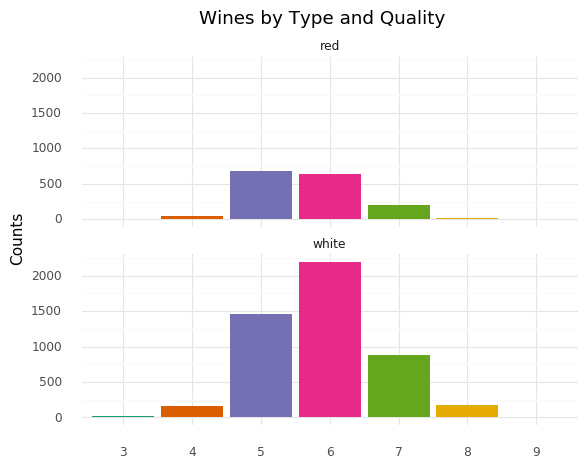

<ggplot: (8781900246445)>

In [563]:
data_toplot = winequality_df.group_by(["type","quality"]).count().get_frame().as_data_frame()
data_toplot = data_toplot.astype({'quality': 'category', 'type': 'category'})

ggplot(data_toplot) + \
    geom_bar(aes(x='quality', y='nrow', fill='quality'), stat = 'identity') + \
    scale_fill_brewer(type = 'qual', palette = 2) + \
    facet_wrap("~type", ncol=1) + \
    labs(title = 'Wines by Type and Quality', x = None, y = 'Counts') + \
    theme_minimal() + \
    theme(legend_position = 'none')

### Cluster wines into exemplars with Aggregator

Our wine dataset has about 6.5K rows:

In [564]:
winequality_df.shape

(6497, 13)

`Aggregator` [requires 2 parameters](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/aggregator.html#defining-an-aggregator-model):
  * `target_num_exemplars`: indicates approximate number of exemplars to build, which in our case effectively defines how much of data reduction (or compression) to perform before using DBSCAN. Since our goal is to reduce dataset size to fit into memory on a client machine for DBSCAN in Python (or R) we aim for 10 fold reduction in size (of course, it will vary for each dataset with this factor going to 100s and higher if necessary). That means that target number of exemplars (`target_num_exemplars`) should be 650.
  * `rel_tol_num_exemplars`: relative tolerance for the number of exemplars (e.g, 0.5 is +/- 50%). We will set tolerance to 25% (0.25). 

There are two features `quality` (dependent variable) and `type` (`'red'` or `'white'` wine) that won't be part of clustering space but for different reasons. While `quality` is excluded because it's a dependent variable, `type` is a categorical variable that DBSCAN doesn't support unless all distances are pre-computed. 

Note, that `type` is binary type of wine - `'red'` or `'white'` - that translates into single numerical (boolean) feature by mapping `'white'` to `0` and `'red'` to `1`. This is effectively an one-hot encoding, which is automatically included in H2O `Aggregator` support for categorical columns (see [H2O Aggregator docs](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/aggregator.html#introduction)).

In [565]:
params = {
    "target_num_exemplars": 650,
    "rel_tol_num_exemplars": 0.25,
    "save_mapping_frame": True
}
agg = H2OAggregatorEstimator(ignored_columns = ['quality', 'type'], **params)
agg.train(training_frame=winequality_df)

# Use the aggregated model to create a new dataframe using aggregated_frame
agg_df = agg.aggregated_frame

aggregator Model Build progress: |████████████████████████████████████████| 100%


#### Support for predicting on Aggregator model is coming

In [566]:
# agg_preds = agg.predict(winequality_df)

### Analyze Aggregator exemplars

#### Number of exemplars found by Aggregator:

In [567]:
agg_df.shape[0]

775

#### Exemplar counts by size

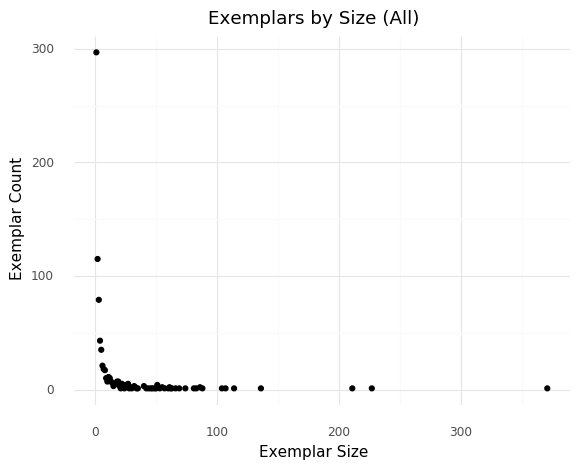

<ggplot: (8781891392289)>

In [568]:
agg_dt = dt.Frame(agg_df.as_data_frame())
agg_dt = agg_dt[:, count(), by(f.counts)]
agg_dt.names = ['exemplar_counts', 'count']
data_toplot = agg_dt.to_pandas()
ggplot(data_toplot)  + \
    geom_point(aes(x='exemplar_counts', y='count')) + \
    labs(title = 'Exemplars by Size (All)', x = "Exemplar Size", y = 'Exemplar Count') + \
    theme_minimal() 

#### Exemplar counts by size (<52)

Zooming in into distribution of exemplars by size for smaller sizes shows:

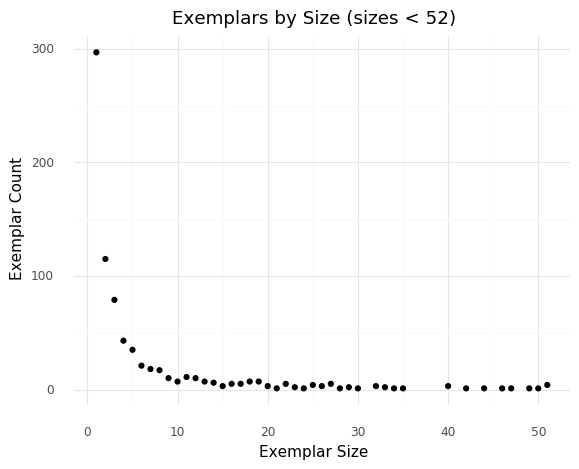

<ggplot: (8781967695365)>

In [569]:
ggplot(data_toplot.loc[data_toplot['exemplar_counts'] < 52])  + \
    geom_point(aes(x='exemplar_counts', y='count')) + \
    labs(title = 'Exemplars by Size (sizes < 52)', x = "Exemplar Size", y = 'Exemplar Count') + \
    theme_minimal() 

#### Exemplar counts by size (>=52)

Zooming in into distribution of exemplars by size for larger sizes shows:

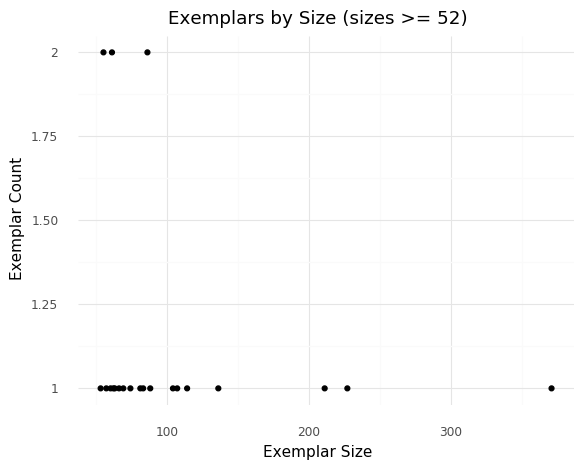

<ggplot: (8781955763285)>

In [570]:
ggplot(data_toplot.loc[data_toplot['exemplar_counts'] >= 52])  + \
    geom_point(aes(x='exemplar_counts', y='count')) + \
    labs(title = 'Exemplars by Size (sizes >= 52)', x = "Exemplar Size", y = 'Exemplar Count') + \
    theme_minimal() 

### Run aggregator on exemplar sizes

Aggregator groups rows (rows) into exemplars (clusters) where each exemplar size is a function of density of wines in the exemplar. The densiest cluster of wines was grouped into the densiest (largest) exemplar with 371 wines while 297 exemplars out of 775 total contain just 1 wine.

To take aggregator functionality to "next level" let's run aggregator on single dimensional set of sizes of exemplars just produced from wine quality data and visualize how exemplar sizes group into exemplars of their own:

In [571]:
params = {
    "target_num_exemplars": 50,
    "rel_tol_num_exemplars": 0.5
}
cols_to_remove = agg_df.columns.remove('counts')
agg_size = H2OAggregatorEstimator(ignored_columns = cols, **params)
agg_size.train(training_frame=agg.aggregated_frame)

agg_size_pd = agg_size.aggregated_frame.as_data_frame()
agg_size_pd[["counts","counts0"]]

aggregator Model Build progress: |████████████████████████████████████████| 100%


,counts,counts0
0,42,5
1,136,1
2,50,6
3,371,1
4,74,1
5,86,3
6,27,15
7,3,591
8,227,1
9,22,18


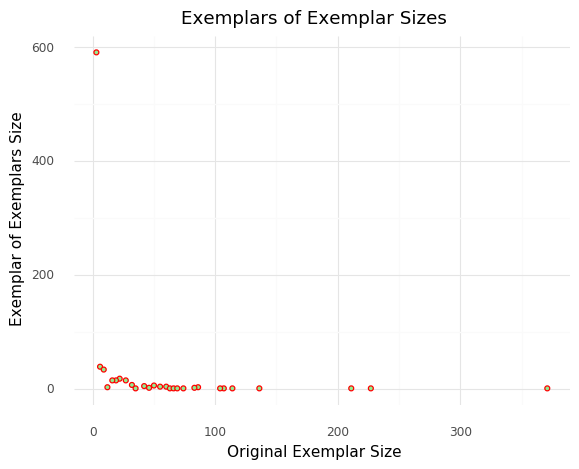

<ggplot: (8781954724337)>

In [572]:
data_toplot = agg_size_pd
ggplot(data_toplot) + \
    geom_point(aes(x='counts', y='counts0'), color='red', fill='lightgreen') + \
    labs(title = 'Exemplars of Exemplar Sizes', x = "Original Exemplar Size", y = "Exemplar of Exemplars Size") + \
    theme_minimal() + \
    theme(legend_position = 'right')

### Run DBSCAN on exemplars

Standardize and run DBSCAN on exemplars produced with H2O `Aggregator`:

In [573]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
agg_pd = agg_df.as_data_frame()
data_to_dbscan = StandardScaler().fit_transform(agg_pd.iloc[:, :-3])
clustering = DBSCAN(eps=1.5, min_samples=20).fit(X = data_to_dbscan, 
                                               sample_weight = agg_pd.iloc[:, -1].ravel())
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Number of clusters: " + str(n_clusters_))
print("Number of exemplars qualified as noise: " + str(n_noise_))

Number of clusters: 4
Number of exemplars qualified as noise: 334


Review credated clusters and remember that label `-1` means that this exemplar was qualified as noise, while label values of `0` and above are clusters:

In [574]:
print("Number of clusters: " + str(n_clusters_))
print("Number of exemplars qualified as noise: " + str(n_noise_))

Number of clusters: 4
Number of exemplars qualified as noise: 334


### Visualize DBSCAN clusters with Principal Components and Features

In [575]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_to_dbscan)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['prcomp1', 'prcomp2'])

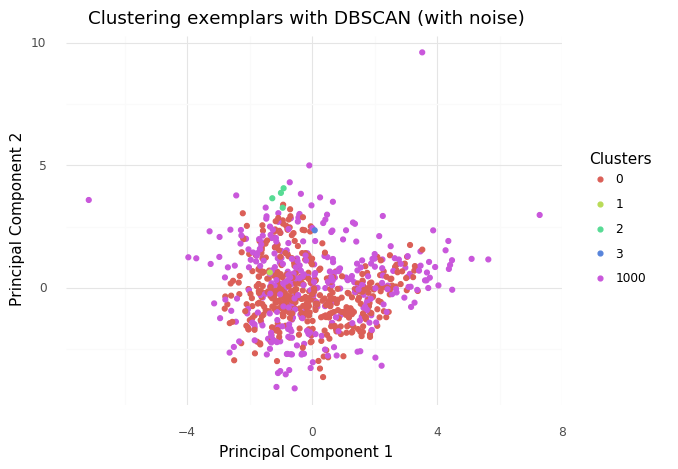

<ggplot: (8781954724153)>

In [576]:
data_to_plot = principalDf
data_to_plot['cluster'] = clustering.labels_
data_to_plot.loc[data_to_plot['cluster'] == -1, 'cluster'] = 1000
data_to_plot = pd.concat([agg_pd, data_to_plot], axis=1)
ggplot(data_to_plot) + \
    geom_point(aes(x='prcomp1', y='prcomp2', color='factor(cluster)')) + \
    scale_color_discrete(name = "Clusters") + \
    labs(title = 'Clustering exemplars with DBSCAN (with noise)', x = "Principal Component 1", 
         y = "Principal Component 2") + \
    theme_minimal() + \
    theme(legend_position = 'right')

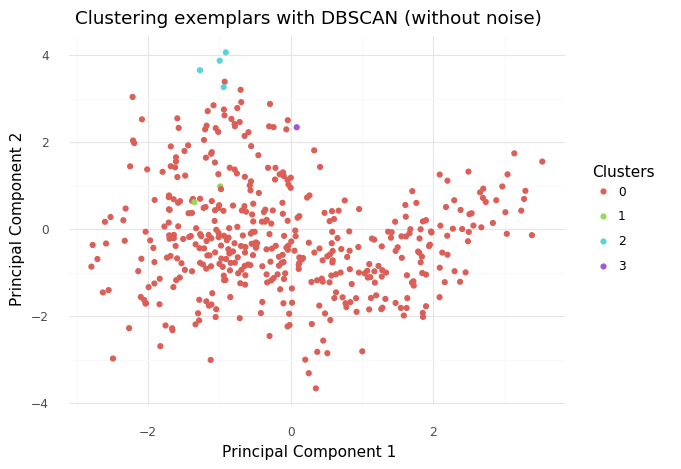

<ggplot: (8781954864269)>

In [577]:
data_to_plot = data_to_plot[data_to_plot['cluster'] < 1000]
ggplot(data_to_plot) + \
    geom_point(aes(x='prcomp1', y='prcomp2', color='factor(cluster)')) + \
    scale_color_discrete(name = "Clusters") + \
    labs(title = 'Clustering exemplars with DBSCAN (without noise)', x = "Principal Component 1", 
         y = "Principal Component 2") + \
    theme_minimal() + \
    theme(legend_position = 'right')

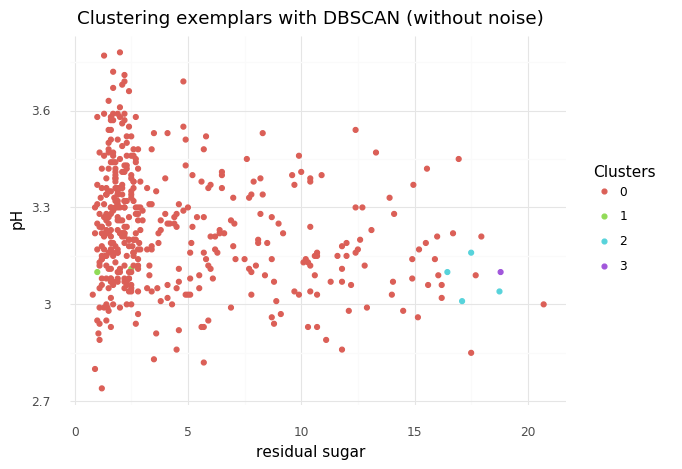

<ggplot: (8781967401417)>

In [578]:
ggplot(data_to_plot) + \
    geom_point(aes(x='residual sugar', y='pH', color='factor(cluster)')) + \
    scale_color_discrete(name = "Clusters") + \
    labs(title = 'Clustering exemplars with DBSCAN (without noise)', x = "residual sugar", 
         y = "pH") + \
    theme_minimal() + \
    theme(legend_position = 'right')